In [2]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
import scipy.signal as signal
from wfdb import processing
from scipy.fftpack import fft, ifft 
import pywt as pw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import Preprocessing
from importlib import reload
import transformers
from transformers import Transformers

loading the signals

In [3]:
reload(Preprocessing)

load = Preprocessing.loadData()
Y,Y.scp_codes = load.example_physionet()
X, meta_data = load.load_raw_data(Y)

origin_signals = np.zeros((21799, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        
        origin_signals[sig, lead, :] = X[sig].T[lead][:] 


Freq Analysis

In [ ]:
reload(transformers)
T = Transformers()
T.FFT(origin_signals[0][0][:])

In [57]:
peaks, _ = find_peaks(smoothed_signal)
r_peak_indices = peaks
print(peaks)
print(r_peak_indices)

[  5  10  17  23  26  33  36  43  50  62  69  75  78  82  92  97 101 104
 110 115 121 125 131 137 144 158 167 170 176 181 185 195 202 208 213 216
 221 225 231 236 245 252 259 262 269 274 279 285 289 294 300 305 309 318
 323 328 335 341 350 357 362 367 373 381 388 393 405 414 422 433 441 446
 451 457 461 471 476 488 495 498 503 511 515 527 533 543 550 559 564 571
 583 590 597 601 610 623 626 634 641 644 648 654 663 668 674 679 685 690
 703 707 725 732 739 742 749 757 762 768 773 782 787 793 802 812 817 823
 829 834 839 844 853 858 865 874 883 892 898 902 908 917 920 925 933 936
 950 961 967 973 989 994]
[  5  10  17  23  26  33  36  43  50  62  69  75  78  82  92  97 101 104
 110 115 121 125 131 137 144 158 167 170 176 181 185 195 202 208 213 216
 221 225 231 236 245 252 259 262 269 274 279 285 289 294 300 305 309 318
 323 328 335 341 350 357 362 367 373 381 388 393 405 414 422 433 441 446
 451 457 461 471 476 488 495 498 503 511 515 527 533 543 550 559 564 571
 583 590 597 601 610 623 

In [4]:
import random

In [21]:
coeffs = pw.swt(origin_signals[0][0][:], wavelet = "db4", level=3, start_level=0, axis=-1)
len(coeffs)

3

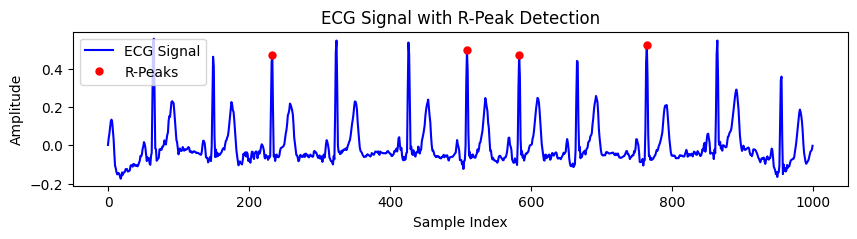

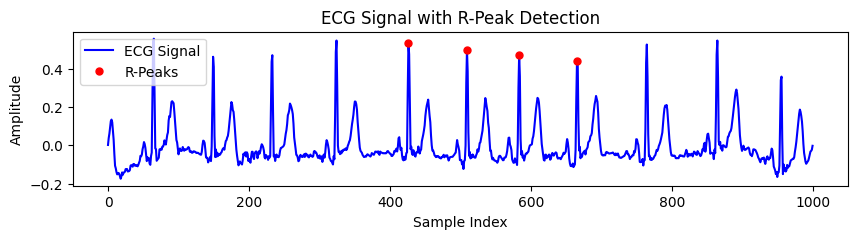

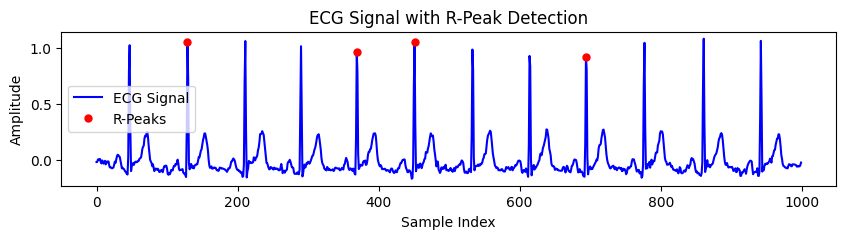

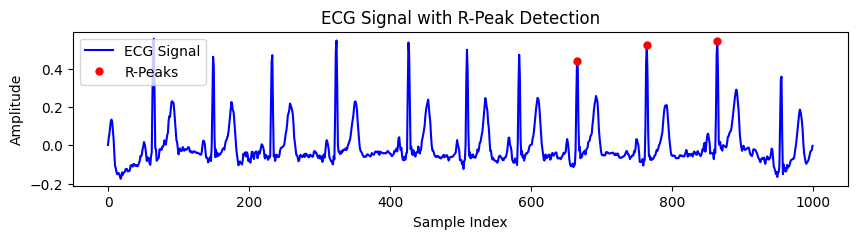

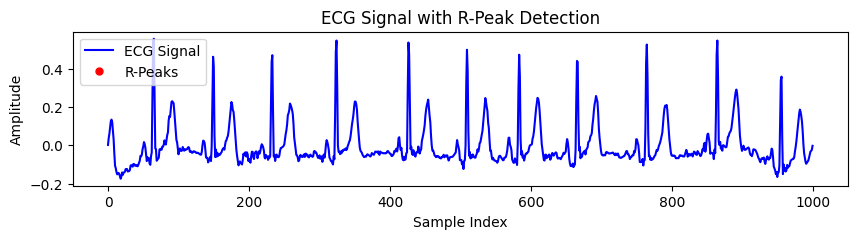

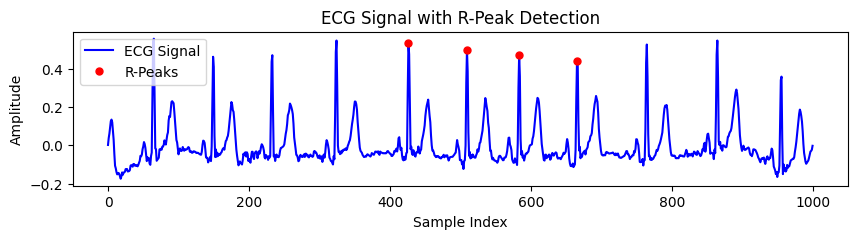

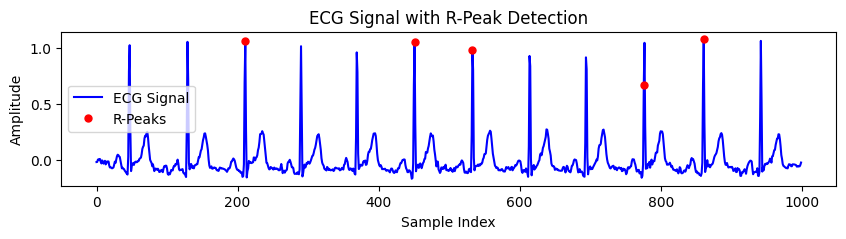

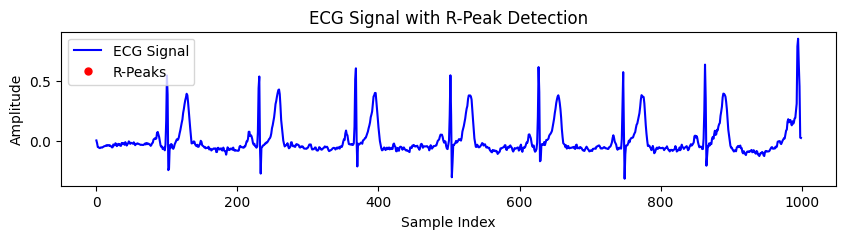

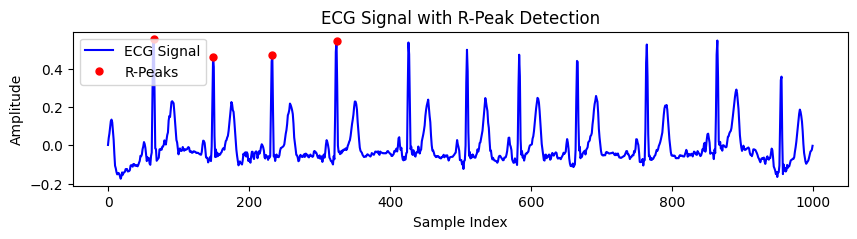

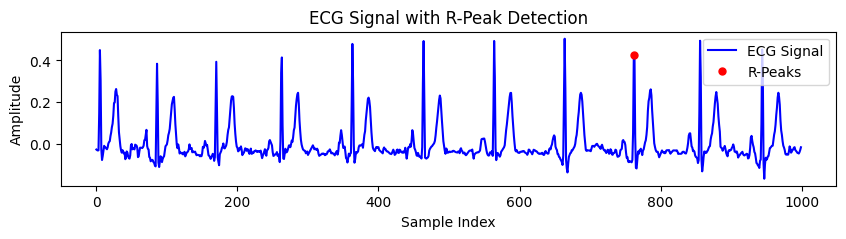

In [38]:
random_numbers = [random.randint(1,2100) for x in range(10)]

for i in random_numbers:
   
    coeffs = pw.swt(loaded_highpassedfiltered_signal[i][0][:], wavelet = "db4", level=3, start_level=0, axis=-1)
    d3 = coeffs[2][1] ##2nd level detail coefficients

    sample_rate = 100
    max_bpm = 66 
    ## Threhold the detail coefficients
    avg = np.mean(d3)
    std = np.std(d3)
    sig_thres = [abs(i) if abs(i)>4.0*std else 0 for i in d3-avg]

    ## Find the maximum modulus in each window
    window = int((60.0/max_bpm)*sample_rate)
    sig_len = len(origin_signals[i][0][:])
    n_windows = int(sig_len/window)
    modulus,qrs = [],[]

    ##Loop through windows and find max modulus
    for i in range(n_windows):
        start = i*window
        end = min([(i+1)*window,sig_len])
        mx = max(sig_thres[start:end])
        if mx>0:
            modulus.append( (start + np.argmax(sig_thres[start:end]),mx))


    ## Merge if within max bpm
    merge_width = int((0.2)*sample_rate)
    i=0
    while i < len(modulus)-1:
        ann = modulus[i][0]
        if modulus[i+1][0]-modulus[i][0] < merge_width:
            if modulus[i+1][1]>modulus[i][1]: # Take larger modulus
                ann = modulus[i+1][0]
            i+=1
                
        qrs.append(ann)
        i+=1 

    
    ## Pin point exact qrs peak
    window_check = int(sample_rate/6)
    #signal_normed = np.absolute((signal-np.mean(signal))/(max(signal)-min(signal)))
    r_peaks = []

    for loc in qrs:
        start = max(0,loc-window_check)
        end = min(sig_len,loc+window_check)
        wdw = np.absolute(loaded_highpassedfiltered_signal[i][0][:][start:end] - np.mean(loaded_highpassedfiltered_signal[i][0][:][start:end]))
        pk = np.argmax(wdw)

        if wdw[pk] >= 0.3:
            r_peaks.append(start + pk)

    plt.figure(figsize=(10, 2))
    plt.plot(loaded_highpassedfiltered_signal[i][0][:], color='blue', label='ECG Signal')
    plt.plot(r_peaks, loaded_highpassedfiltered_signal[i][0][:][r_peaks], 'ro', markersize=5, label='R-Peaks')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with R-Peak Detection')
    plt.legend()
    plt.show()

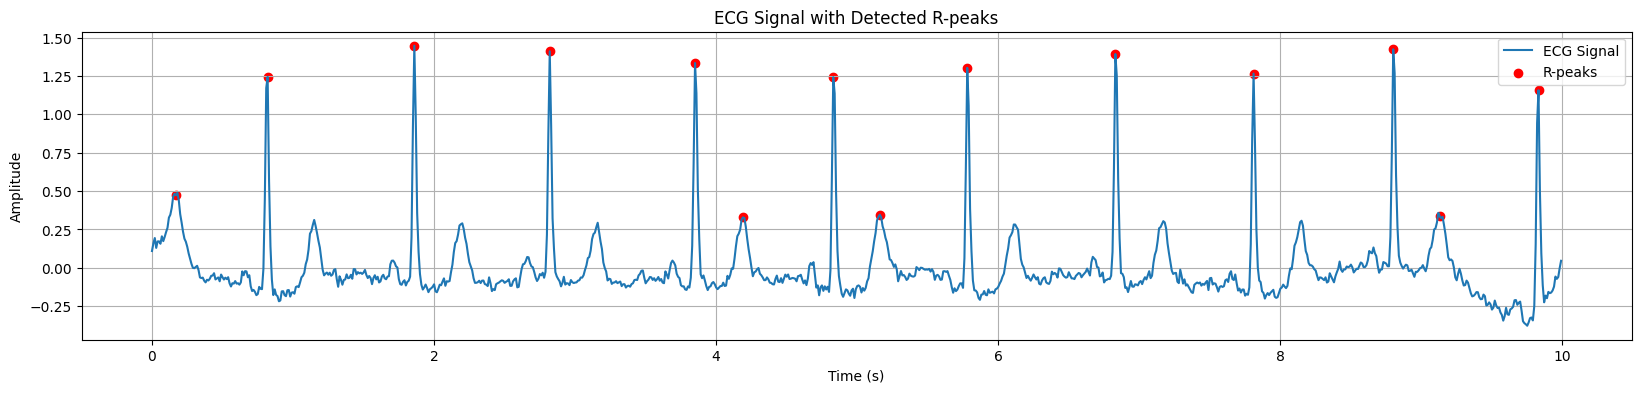

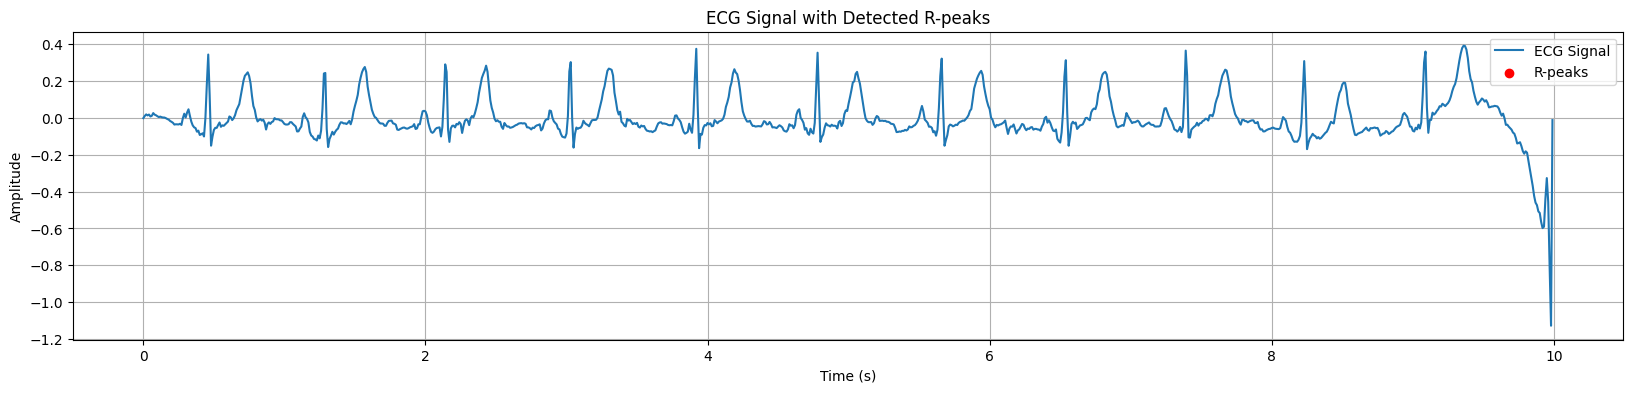

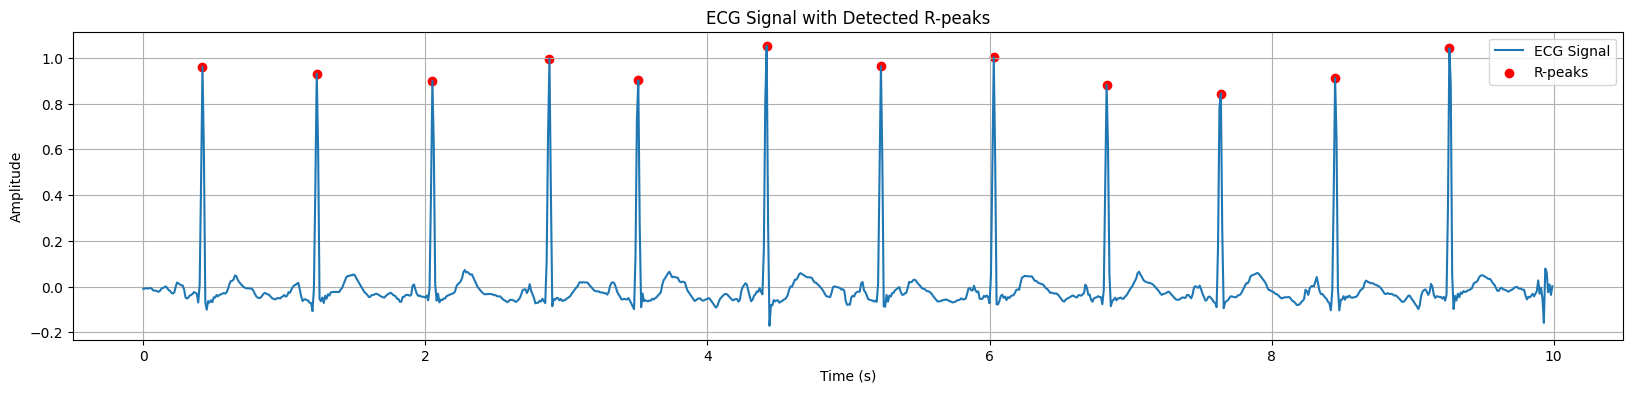

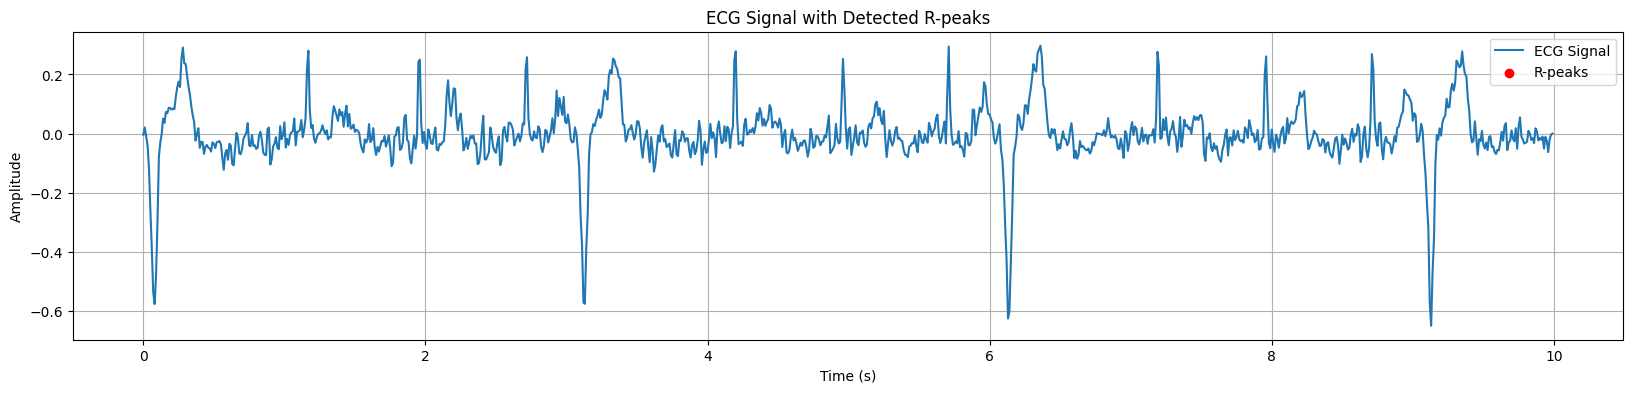

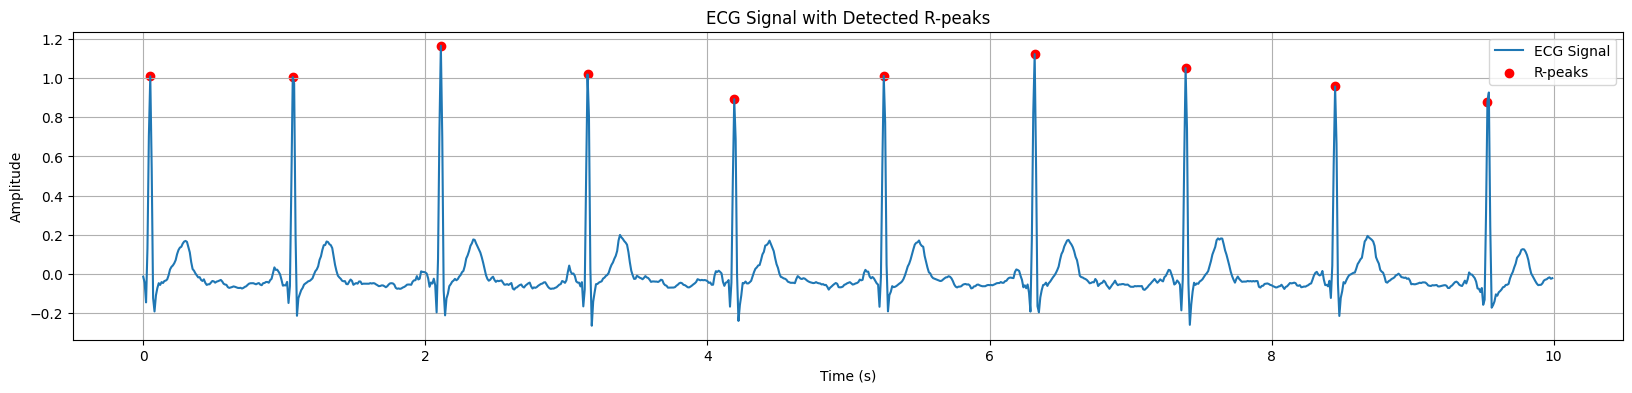

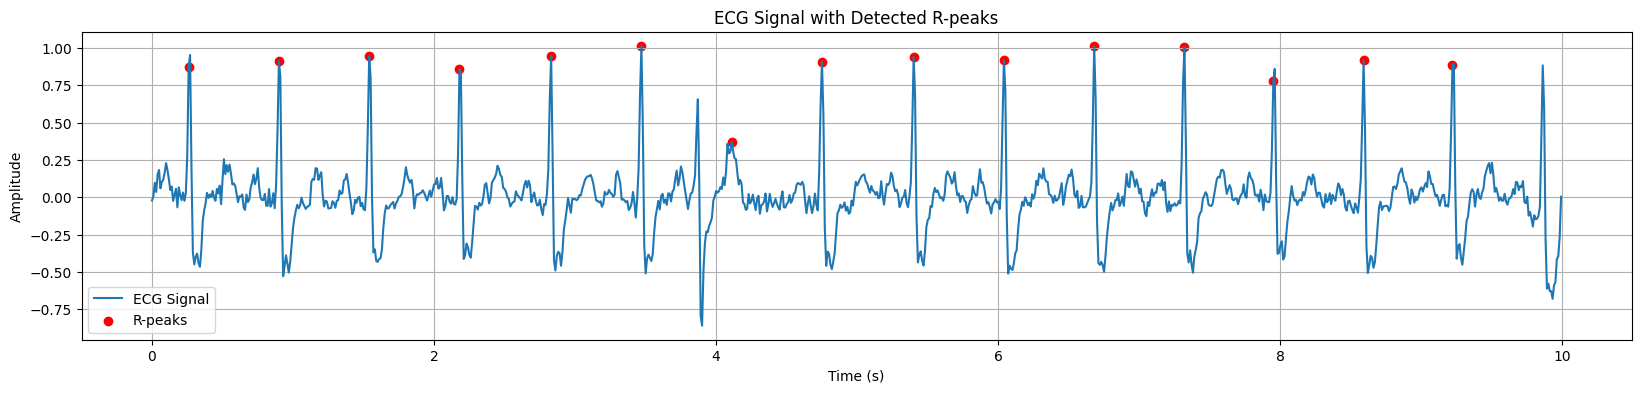

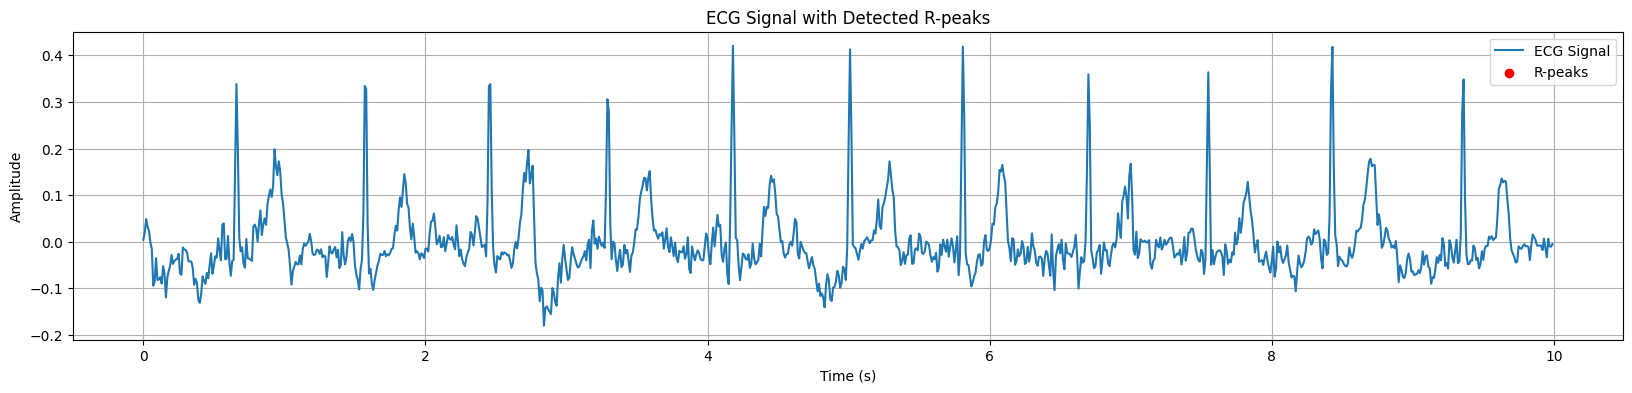

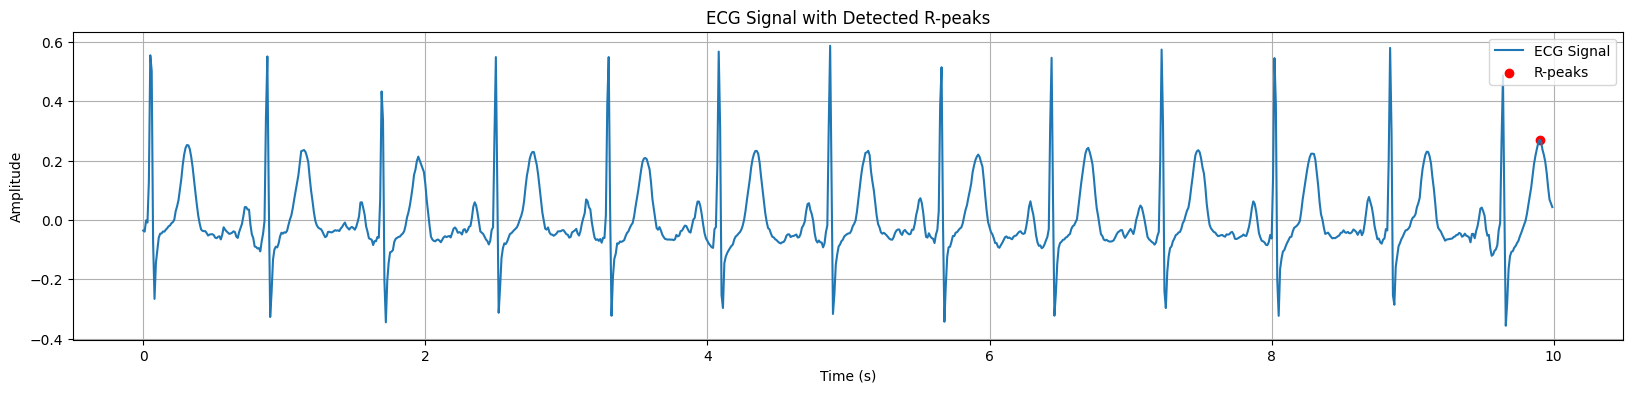

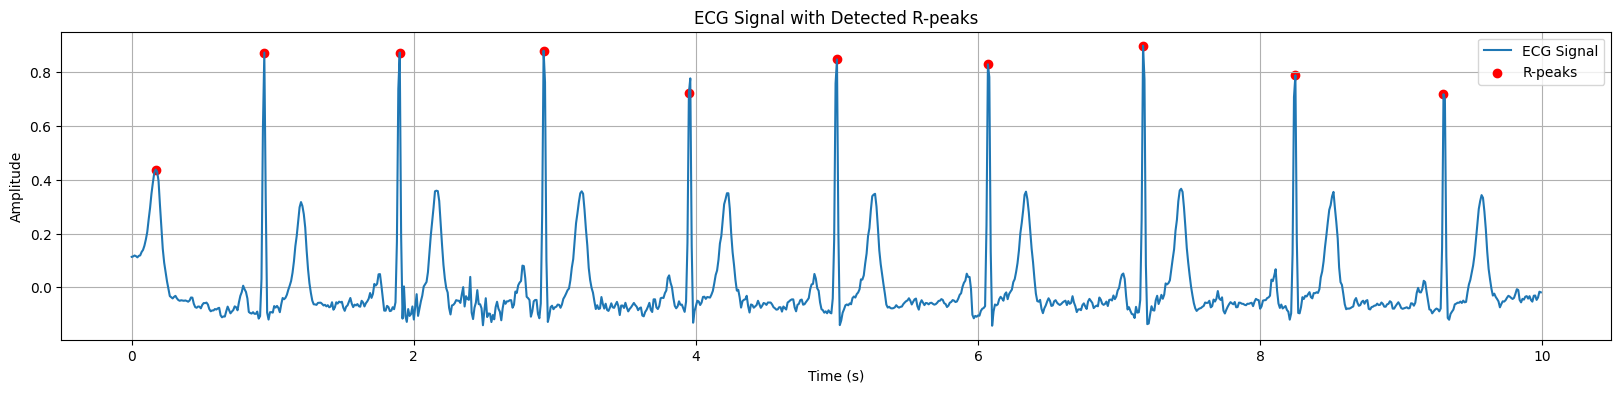

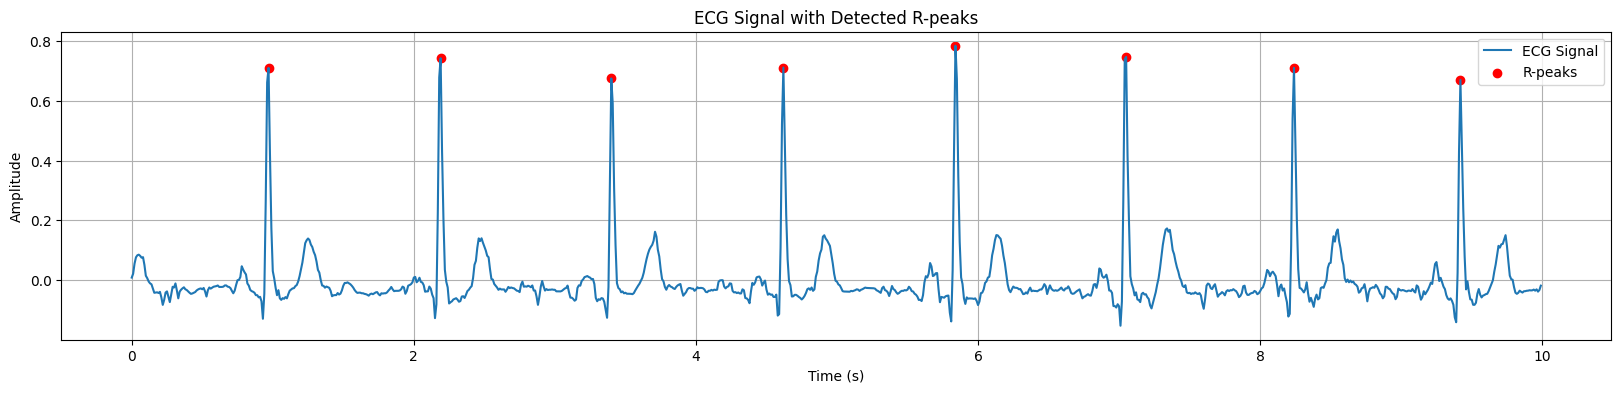

In [96]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def detect_r_peaks(ecg_signal, sampling_rate, min_distance, threshold):
    # Bandpass filter to remove noise and isolate QRS complex
    lowcut = 0.5  # Low cutoff frequency in Hz
    highcut = 15.0  # High cutoff frequency in Hz
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)
    
    # Find R-peaks using peak detection with a threshold
    r_peaks, _ = signal.find_peaks(filtered_ecg, distance=min_distance, height=threshold)
    
    return r_peaks

random_numbers = [random.randint(1,2100) for x in range(10)]
sampling_rate = 100  # Replace with the actual sampling rate of your ECG signal
min_distance = 30
threshold = 0.3 # Adjust the threshold as needed

for i in random_numbers:

    # Example usage
    ecg_signal = loaded_highpassedfiltered_signal[i][0][:]
    r_peaks = detect_r_peaks(ecg_signal, sampling_rate, min_distance, threshold)

    # Plot the ECG signal and detected R-peaks
    time = np.arange(len(ecg_signal)) / sampling_rate
    plt.figure(figsize=(20,4))
    plt.plot(time, ecg_signal, label='ECG Signal')
    plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with Detected R-peaks')
    plt.legend()
    plt.grid(True)
    plt.show()


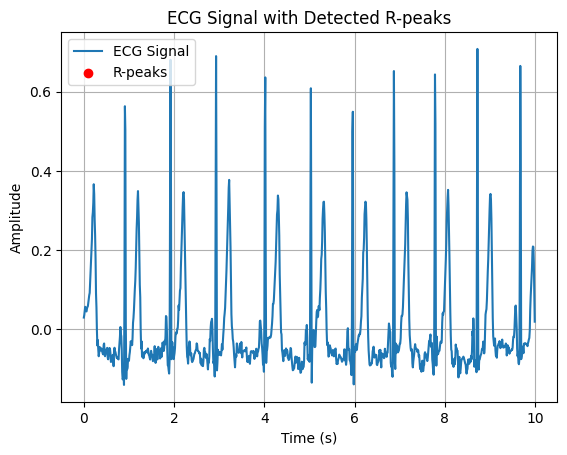

In [66]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def detect_r_peaks(ecg_signal, sampling_rate, min_distance, threshold):
    # Bandpass filter to remove noise and isolate QRS complex
    lowcut = 0.5  # Low cutoff frequency in Hz
    highcut = 15.0  # High cutoff frequency in Hz
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)
    
    # Differentiation to accentuate R-peaks
    diff_ecg = np.diff(filtered_ecg)
    
    # Squaring to emphasize the QRS complex
    squared_ecg = diff_ecg**2
    
    # Moving window integration to smooth and sum the squared values
    window_size = int(0.15 * sampling_rate)
    integrated_ecg = np.convolve(squared_ecg, np.ones(window_size), mode='valid')
    
    # Pad the integrated_ecg array to match the size of filtered_ecg
    pad_width = len(filtered_ecg) - len(integrated_ecg)
    integrated_ecg = np.pad(integrated_ecg, (0, pad_width), mode='constant')
    
    # Find R-peaks using adaptive thresholding
    peak_threshold = 0.5 * np.max(integrated_ecg)
    r_peaks = np.where((integrated_ecg > peak_threshold) & (filtered_ecg > threshold))[0] + (window_size // 2)
    
    # Remove peaks that are too close to each other
    valid_r_peaks = []
    last_peak = min_distance - 1
    for peak in r_peaks:
        if peak - last_peak > min_distance:
            valid_r_peaks.append(peak)
            last_peak = peak
    
    return valid_r_peaks
    
    
# Example usage
ecg_signal = loaded_highpassedfiltered_signal[200][0][:]
sampling_rate = 100
min_distance = 5
threshold = 0.4  # Specify the desired threshold value
num_peaks = 11
window_size = int(10 * sampling_rate)
overlap = int(1 * sampling_rate)
r_peaks = []

# Iterate over sliding windows to detect R-peaks
start = 0
while start + window_size <= len(ecg_signal):
    window_ecg = ecg_signal[start:start + window_size]
    window_r_peaks = detect_r_peaks(window_ecg, sampling_rate, min_distance, threshold)
    
    if len(r_peaks) + len(window_r_peaks) >= num_peaks:
        remaining_peaks = num_peaks - len(r_peaks)
        r_peaks.extend(window_r_peaks[:remaining_peaks])
        break
    else:
        r_peaks.extend(window_r_peaks)
    
    start += window_size - overlap

# Plot the ECG signal and detected R-peaks
time = np.arange(len(ecg_signal)) / sampling_rate
plt.figure()
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected R-peaks')
plt.legend()
plt.grid(True)
plt.show()


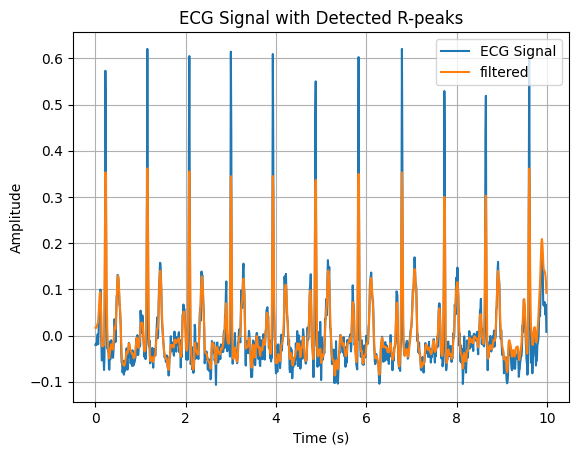

In [64]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def detect_r_peaks(ecg_signal, sampling_rate, min_distance_sec, threshold):
    # Bandpass filter to remove noise and isolate QRS complex
    lowcut = 0.5  # Low cutoff frequency in Hz
    highcut = 15.0  # High cutoff frequency in Hz
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)
    
    # Calculate minimum distance in samples
    min_distance_samples = int(min_distance_sec * sampling_rate)
    
    # Find R-peaks using peak detection with a threshold and minimum distance
    r_peaks, _ = signal.find_peaks(filtered_ecg, distance=min_distance_samples, height=threshold)
    
    return r_peaks


# Example usage
ecg_signal = loaded_highpassedfiltered_signal[0][0][:]
sampling_rate = 100  # Replace with the actual sampling rate of your ECG signal
min_distance_sec = 0.2  # Minimum distance between R-peaks in seconds
threshold = 0.4  # Adjust the threshold as needed

r_peaks = detect_r_peaks(ecg_signal, sampling_rate, min_distance_sec, threshold)

# Plot the ECG signal and detected R-peaks
time = np.arange(len(ecg_signal)) / sampling_rate
plt.figure()
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected R-peaks')
plt.legend()
plt.grid(True)
plt.show()


baseline wander removal = low-frequency drift

In [12]:
import scipy.signal as signal
baseline_removed_ecg = np.zeros((21799, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        

        nyquist_freq = 0.5 * 100
        cutoff_freq = 0.5 
        filter_order = 4

        # Design a Butterworth highpass filter
        b, a = signal.butter(filter_order, cutoff_freq / nyquist_freq, btype='highpass')

        # Apply the filter to the ECG signal
        baseline_removed_ecg[sig][lead] = signal.filtfilt(b, a, X[sig].T[lead][:])

Bandpass filter 

In [ ]:
ecg = X[0].T[0][:]

# Design the bandpass filter
f_low = 5  # Lower cutoff frequency
f_high = 40  # Upper cutoff frequency
order = 4  # Filter order
b, a = signal.butter(order, [f_low, f_high], btype='band', fs=100)

# Apply the bandpass filter to the signal
filtered_signal = signal.lfilter(b, a, x)

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x, 'b')
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal, 'r')
plt.title("Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [ ]:
fig = plt.figure(figsize=(20, 50))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

# Frequency Domain

ecg_spectrum = np.fft.fft(filtered_data[0][0][:])
freq = np.fft.fftfreq(baseline_removed_ecg[0].shape[1], d=1/100)

# Plot frequency spectrum
plt.figure(figsize=(20,10))
plt.plot(freq, np.abs(ecg_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your filtered data is stored in a variable called "filtered_data"
signal = X[0].T[0][:]

# Calculate the Fourier transform of the signal
signal_spectrum = np.fft.fft(signal)

# Calculate the frequency axis for the spectrum
freq_axis = np.fft.fftfreq(len(signal), d=1/100)

# Plot the frequency spectrum
plt.plot(freq_axis, np.abs(signal_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Find the maximum frequency present in the signal
max_freq = np.max(freq_axis[np.abs(signal_spectrum) > 0.1*np.max(np.abs(signal_spectrum))])
print("Maximum frequency present in the signal: {:.2f} Hz".format(max_freq))


Text(0.5, 1.0, 'baseline filtered ECG')

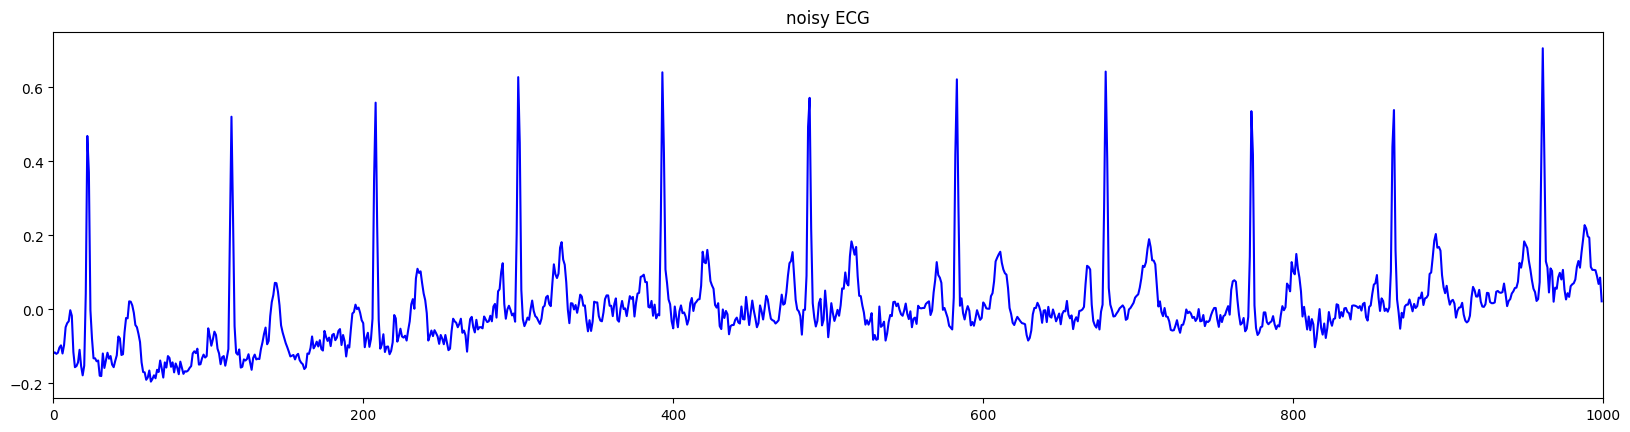

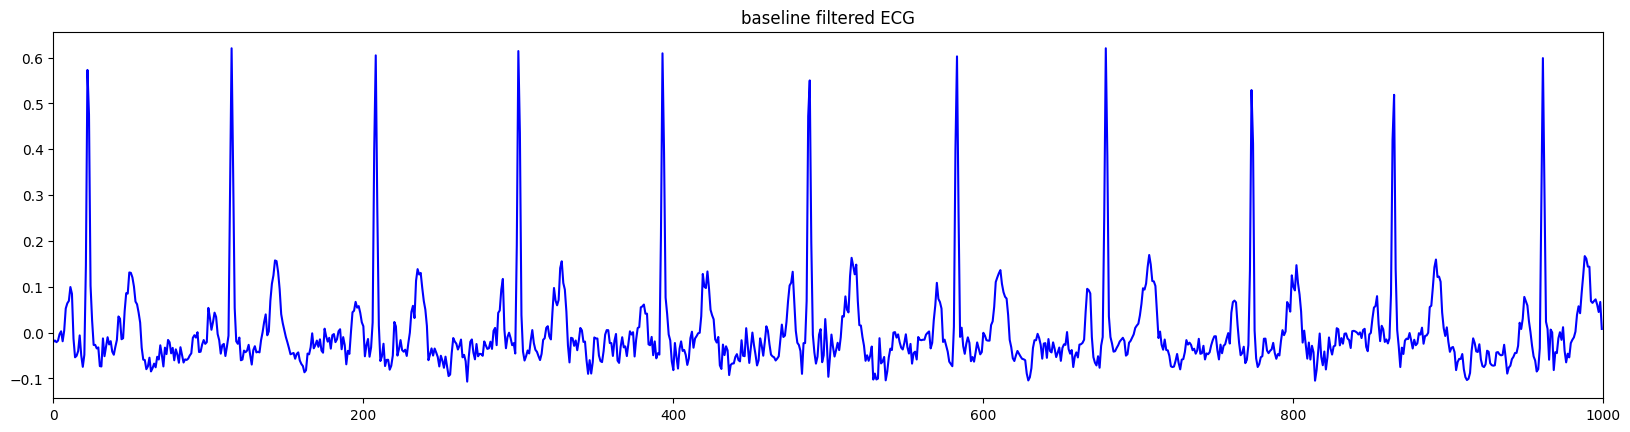

In [14]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('noisy ECG')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(baseline_removed_ecg[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('baseline filtered ECG')

In [12]:
# np.save('highpass_filtered.npy', filtered_data)

In [34]:
loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')

In [ ]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[11][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered_data[0][11], color = 'blue')
arr_signal.set_xlim(0, 1000)

band pass filter

In [22]:
from scipy import signal

filtered_data_newversion_3 = np.zeros((21799, 12, 1000))
ecg = loaded_highpassedfiltered_signal[0][0][:]

lowcut = 0.5 
highcut = 15 
order = 4  
nyquist_freq = 0.5 * 100
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = signal.butter(order, [low, high], btype='band')

filtered = signal.filtfilt(b, a, ecg)

In [23]:
filtered.shape

(1000,)

In [26]:
derivative_coeffs = np.array([-1, 0, 1])

# Apply the derivative filter to the ECG signal
derivative_signal = signal.lfilter(derivative_coeffs, 1, filtered)

In [32]:
MovingAvarage_filtered.shape

(1000,)

In [ ]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('original signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered, color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('bandpass filtered signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(derivative_signal, color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('derivative filtered signal')

In [19]:
import scipy.signal as signal
Highpassesfiltered_data_version2 = np.zeros((21799, 12, 1000))

for sig in range(filtered_data_newversion.shape[0]):
    for lead in range(filtered_data_newversion.shape[1]):
        
        nyquist_freq = 0.5 * 100
        cutoff_freq = 0.5 
        filter_order = 4

        # Design a Butterworth highpass filter
        b, a = signal.butter(filter_order, cutoff_freq / nyquist_freq, btype='highpass')

        # Apply the filter to the ECG signal
        Highpassesfiltered_data_version2[sig][lead] = signal.filtfilt(b, a, filtered_data_newversion[sig][lead][:])


Moving Average Filter

In [29]:
MovingAvarage_filtered = np.zeros((21799, 12, 1000))
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

# for sig in range(Highpassesfiltered_data_version2.shape[0]):
#     for lead in range(Highpassesfiltered_data_version2.shape[1]):
MovingAvarage_filtered = np_move_avg(filtered, 3)


Text(0.5, 1.0, 'moving average filtered signal')

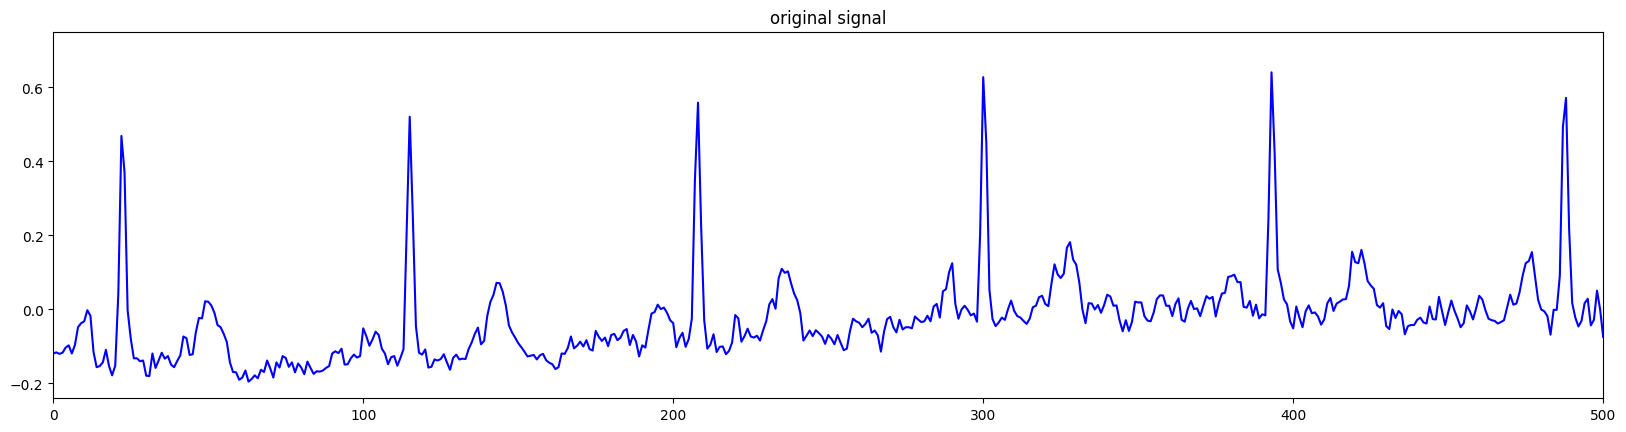

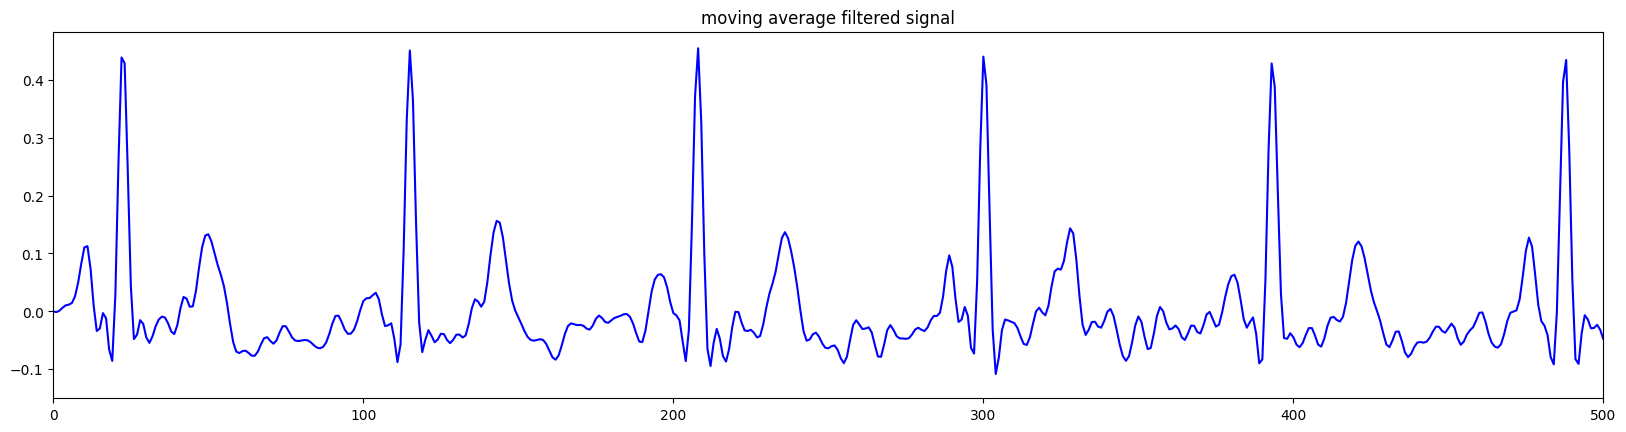

In [49]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 500)
plt.title('original signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered, color = 'blue')
arr_signal.set_xlim(0, 500)
plt.title('moving average filtered signal')

# fig = plt.figure(figsize=(20, 20))
# grid = plt.GridSpec(3, 1, hspace=0.6)
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(filtered_data_newversion[0][0], color = 'blue')
# arr_signal.set_xlim(0, 1000)
# plt.title('bandpass filtered signal')

# fig = plt.figure(figsize=(20, 20))
# grid = plt.GridSpec(3, 1, hspace=0.6)
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(Highpassesfiltered_data_version2[0][0], color = 'blue')
# arr_signal.set_xlim(0, 1000)
# plt.title('bandpass filtered signal version 2')

# fig = plt.figure(figsize=(20, 20))
# grid = plt.GridSpec(3, 1, hspace=0.6)
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(MovingAvarage_filtered[0][0], color = 'blue')
# arr_signal.set_xlim(0, 1000)
# plt.title('mving average filtered signal')

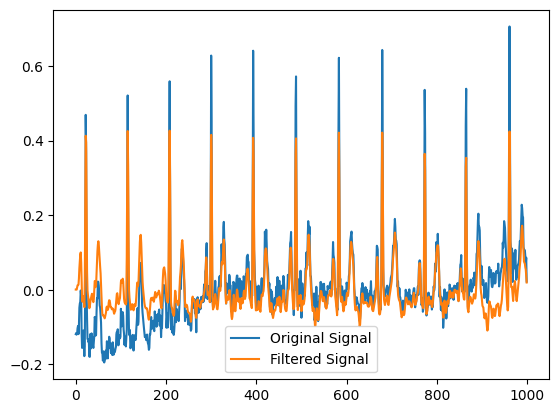

In [44]:
import numpy as np
import matplotlib.pyplot as plt



# Define the filter kernel (in this case, a moving average filter)
window_size = 3
kernel = np.ones(window_size) / window_size

# Apply the filter to the data
y_filtered = np.convolve(filtered, kernel, mode='same')

# Plot the results
plt.plot(X[0].T[0][:], label='Original Signal')
plt.plot(y_filtered, label='Filtered Signal')
plt.legend()
plt.show()


FEATURE EXTRACTION STEP

R-R interval

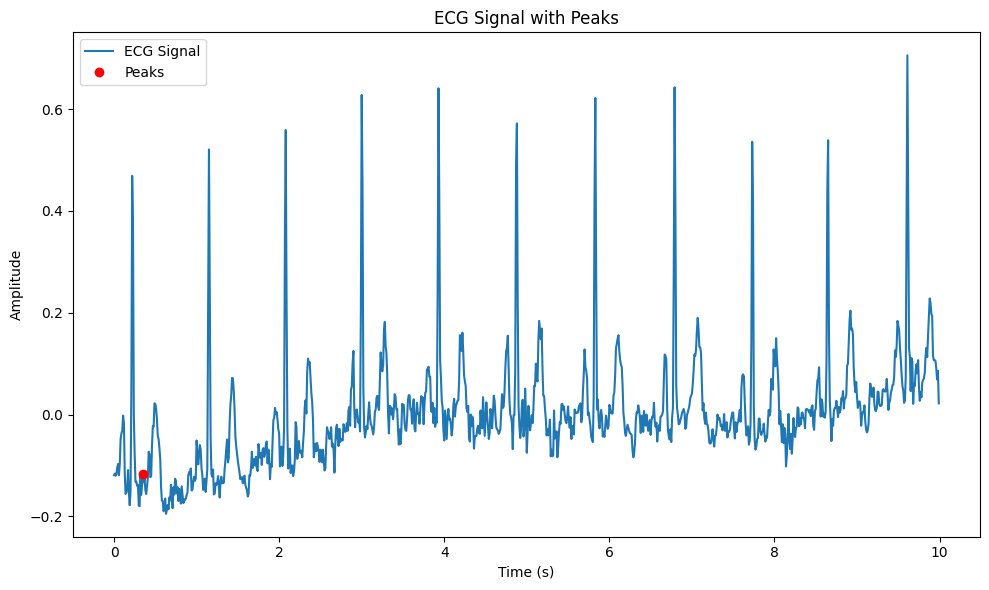

In [8]:
# Load your ECG signal from the dataset into the `ecg_signal` array
# Make sure to adjust the sampling rate (`sampling_rate`) accordingly
ecg_signal = X[0].T[0][:]
# Perform wavelet decomposition using the discrete wavelet transform (DWT)
wavelet = 'db4'  # Wavelet type
level = 5  # Decomposition level
coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

# Extract the approximation coefficients (low-frequency components) at the highest level
approx_coeffs = coeffs[0]

# Perform peak detection on the approximation coefficients
peaks, _ = find_peaks(approx_coeffs, distance=sampling_rate)

# Plot the original ECG signal
t = np.arange(len(ecg_signal)) / sampling_rate
plt.figure(figsize=(10, 6))
plt.plot(t, ecg_signal, label='ECG Signal')
plt.title('ECG Signal with Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the detected peaks
peak_times = peaks / sampling_rate
plt.plot(peak_times, ecg_signal[peaks], 'ro', label='Peaks')

plt.legend()
plt.tight_layout()
plt.show()


TRAIN 

In [15]:
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# agg_df.head()

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y.diagnostic_superclass.to_csv('diagnostic_superclass', index=None)

In [16]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass